# About the notebook
This notebook is an exploratory data analysis for the acacdemic success Dataset and an implementation of ML models to predict the risk of students in higher education.

References:


*   Dataset: [Predict Students' Dropout and Academic Success](https://www.kaggle.com/datasets/mattop/predict-students-dropout-and-academic-success/data)
*   Data description: [UC Irvine repository](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#About the dataset
In the dataset provided by Kaggle, each instance corresponds to a student at a Portugese university. In the original dataset there are 4424 students, however Kaggle has generated more than 10000 synthetic samples based the original dataset.

Each instance is provided with information about its academic performance, demographics, and social-economic factors. Our goal is to predict the situation of the students after 3-4 years of study: either **graduate**d, still **enrolled**, or **dropped out**.

In [7]:
! mkdir train
! unzip playground-series-s4e6.zip -d train

Archive:  playground-series-s4e6.zip
  inflating: train/sample_submission.csv  
  inflating: train/test.csv          
  inflating: train/train.csv         


# Read the data
The training set has about 76000 samples and 36 features

In [8]:
train = pd.read_csv("train/train.csv")
test = pd.read_csv("train/test.csv")

In [9]:
train

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,76513,1,17,1,9254,1,1,121.0,1,19,...,0,6,8,5,10.600000,0,13.9,-0.3,0.79,Graduate
76514,76514,1,1,6,9254,1,1,125.0,1,1,...,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,Graduate
76515,76515,5,17,1,9085,1,1,138.0,1,37,...,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,Enrolled
76516,76516,1,1,3,9070,1,1,136.0,1,38,...,0,6,0,0,0.000000,0,7.6,2.6,0.32,Dropout


#Class distribution
There are 3 target classes:

1.   Graduate
2.   Enrolled
3.   Dropout

According to the pie chart, the classes are not totally unbalanced. However, bias towards predicting the majority class (Graduate) should be considered when building predictive models.




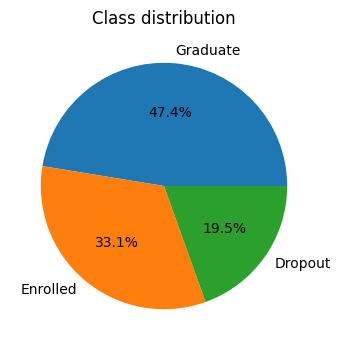

In [10]:
train["Target"].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(train["Target"].value_counts(), labels=["Graduate", "Enrolled", "Dropout"], autopct='%1.1f%%')
plt.title("Class distribution")
plt.show()

#Feature distributions

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

We encode categorical features with a categorical dtype

In [15]:
features = list(train.columns)
features.remove("Target")
features.remove("id")

In [16]:
cat_features = ['Marital status', 'Application mode', 'Course',
                'Previous qualification', 'Nacionality', "Mother's qualification",
                "Father's qualification", "Mother's occupation",
                "Father's occupation"]

In [17]:
for feature in cat_features:
  dtype = pd.CategoricalDtype(categories=list(set(train[feature]) | set(test[feature])))
  train[feature] = train[feature].astype(dtype)
  test[feature] = test[feature].astype(dtype)

We can now plot the feature distributions:


*   Integer features (e.g., application order) are plotted as blue bar charts
*   Categorical features (e.g., marital status) are plotted as black bar charts
*   Float features (e.g., admission grade) are plotted as green histograms.

We can notice that some features are quite imbalance. For example, there are 18 nationalities but 99% of the students are Portugese.


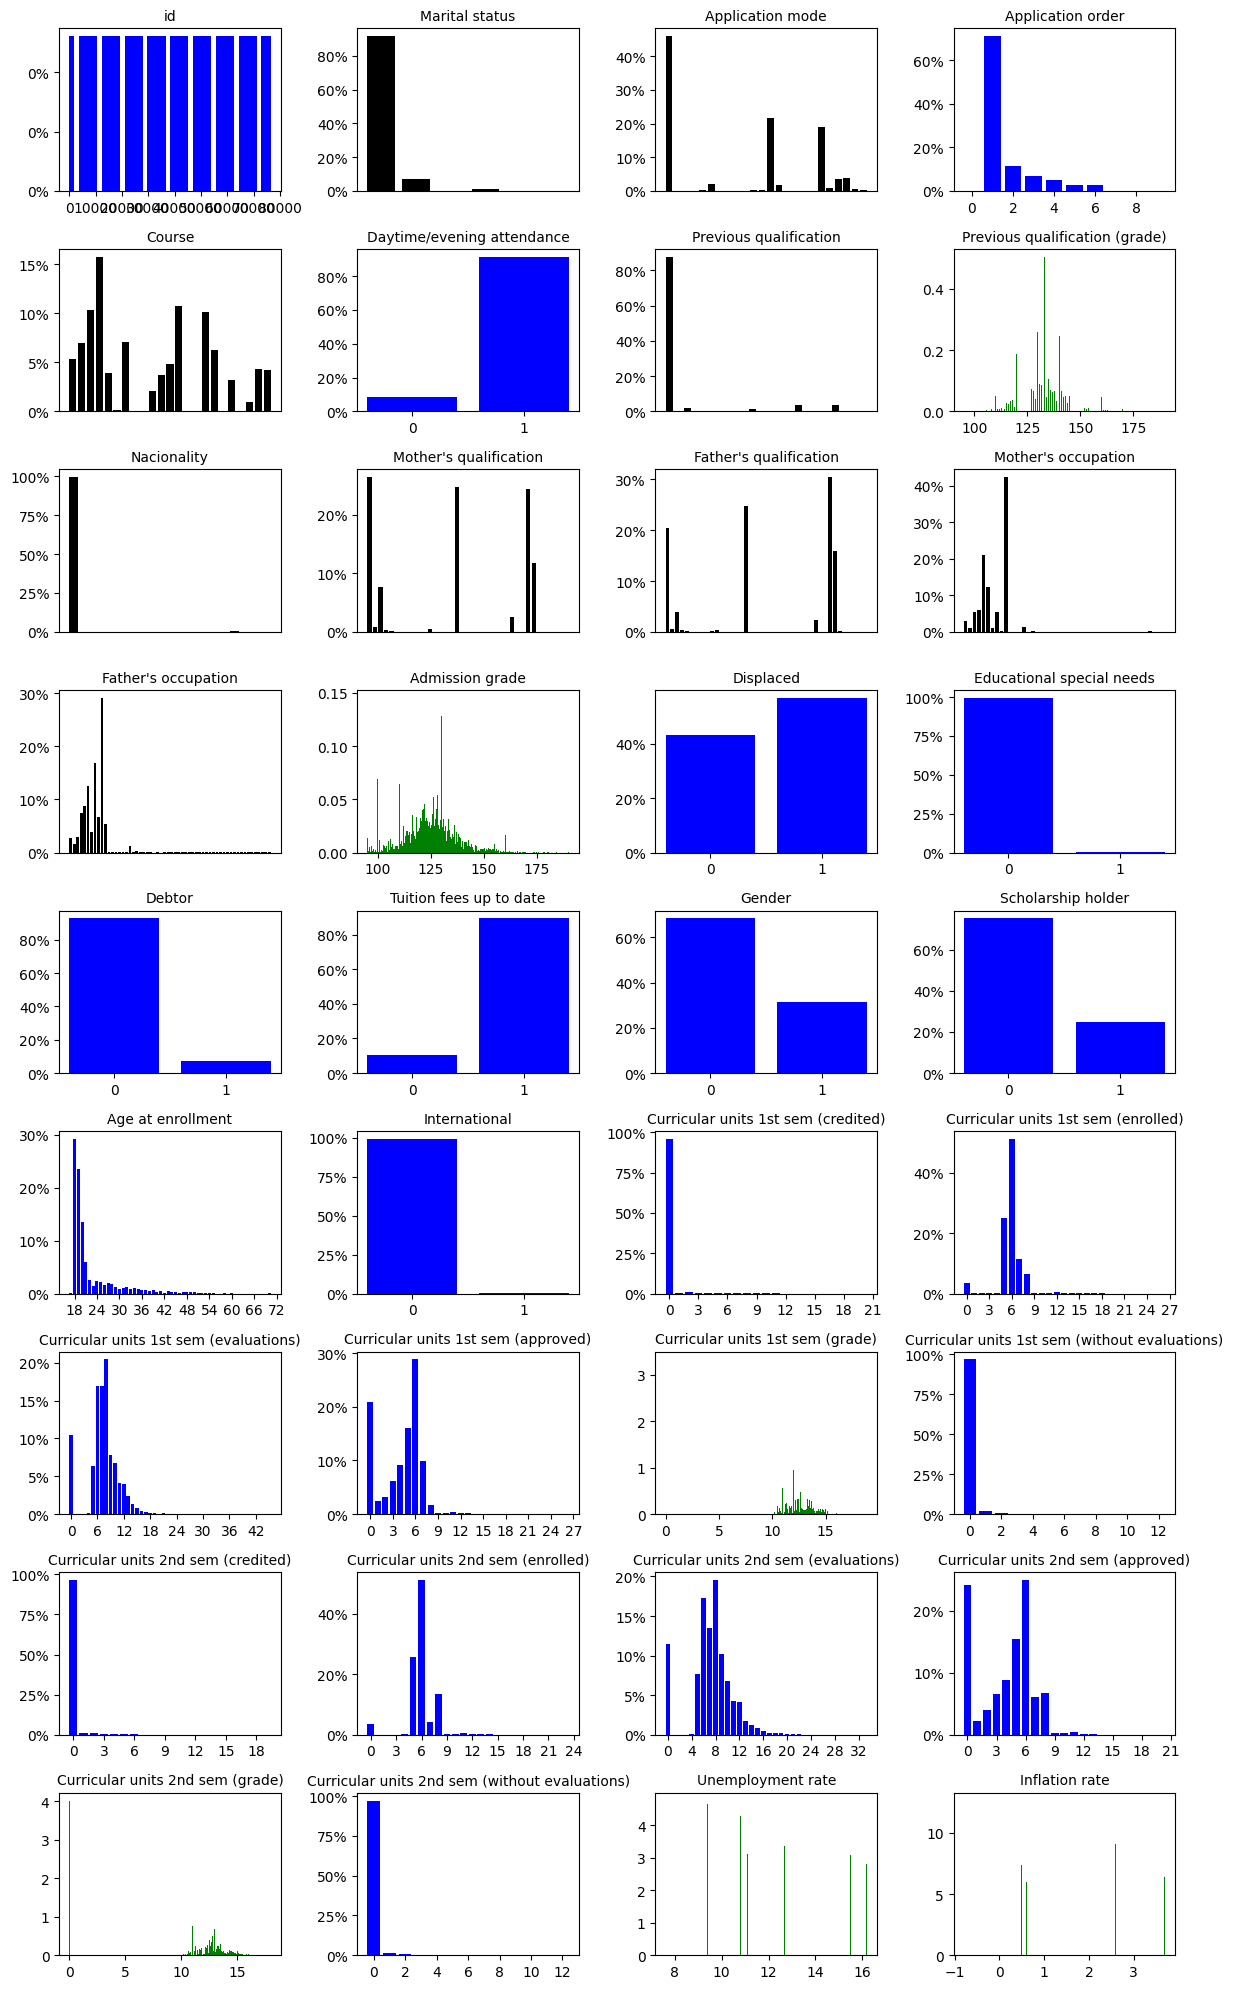

In [18]:
_, axs = plt.subplots(nrows=9, ncols=4, figsize=(12, 20))
for col, ax in zip(features, axs.ravel()):
  if train[col].dtype == 'category':
    vc = train[col].cat.codes.value_counts() / len(train)
    ax.bar(vc.index, vc, color='k')
    ax.yaxis.set_major_formatter('{x:.0%}')
    ax.set_xticks([])
  elif train[col].dtype == float:
    ax.hist(train[col], bins=300, density=True, color='g')
  else:
    vc = train[col].value_counts() / len(train)
    ax.bar(vc.index, vc, color='b')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter('{x:.0%}')
  ax.set_title(col, fontsize=10)
plt.tight_layout()
plt.show()


#Feature correlations

All correlations are multiplied by 10 for better readability

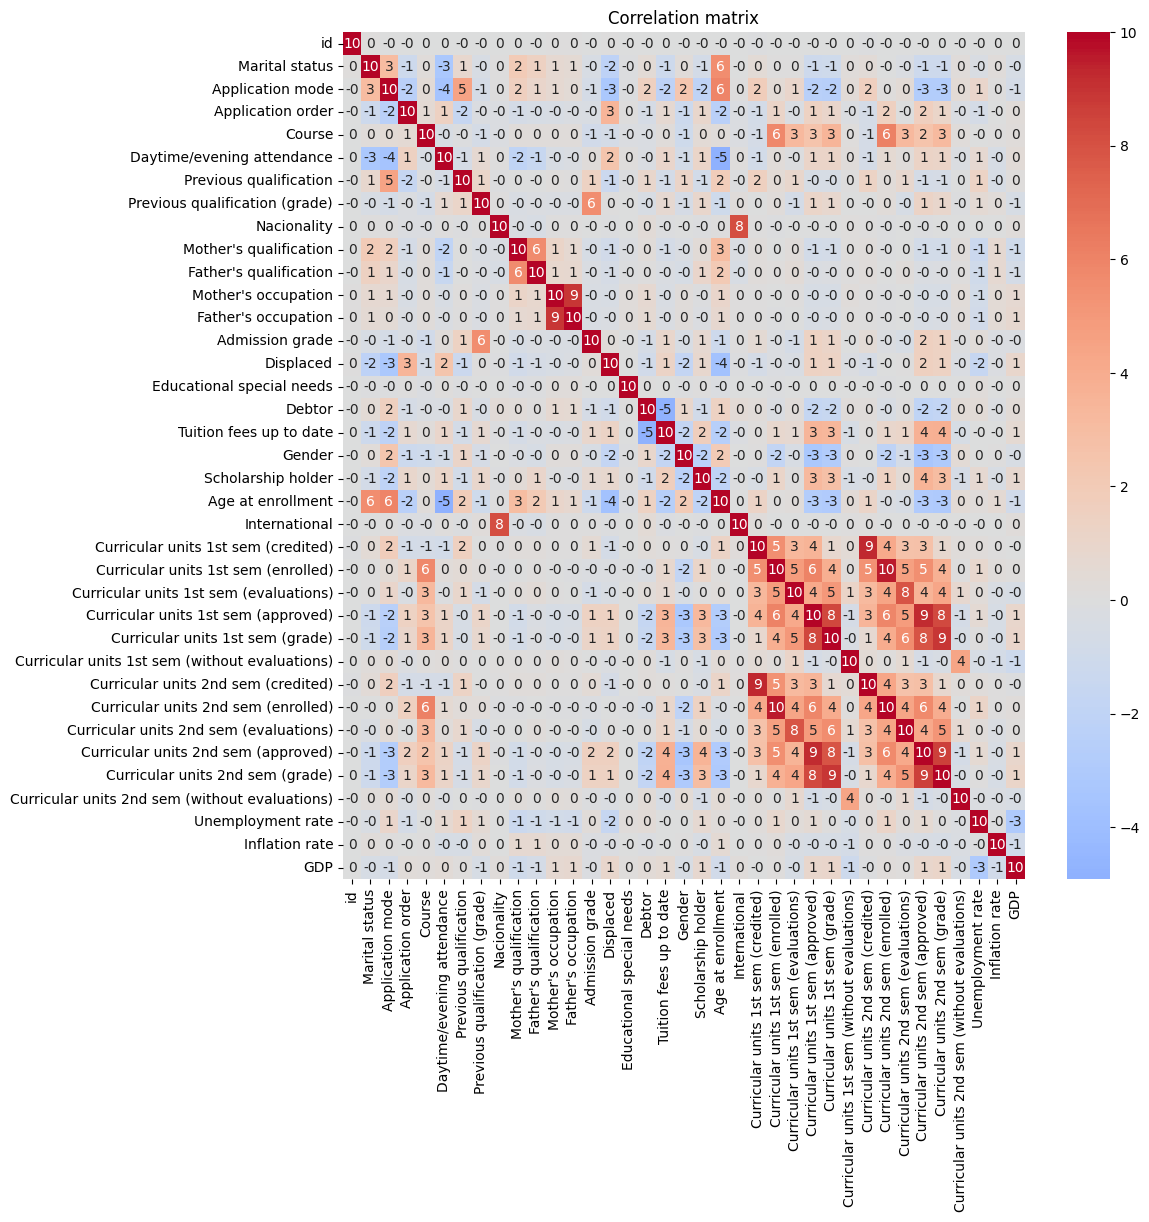

In [19]:
corr_features = features
coef = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(coef*10, center=0, cmap='coolwarm', annot=True, fmt='.0f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

We can see some correlation, for example:


*   All the statistics about "curricular units" are correlated.
*   Nationality is correlated to the binary 'international' feature. However, they do not correlated to other features, we can drop these in the training set
*   Marital status is correlated with age.
*   Mother's occupation and father's occupation are highly correlated
*   Most 'curricular units' features are correlated



#Data Preprocessing

In [22]:
train['Target'] = train['Target'].map({'Graduate': 0, 'Dropout': 1, 'Enrolled': 2})

In [23]:
def fill_missing_numerical_value(df):
  numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
  df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
  return df

def convert_cat_value(df):
  cat_cols = df.select_dtypes(include=['object']).columns.tolist()
  cat_cols = [col for col in cat_cols if col != 'Target']
  df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
  return df

def data_preprocessing(df, train=True):
  ids = df.pop('id')

  df = df.drop(columns=['Nacionality', 'International'])
  df = fill_missing_numerical_value(df)
  df = convert_cat_value(df)

  if train:
    targets = df.pop('Target')
    return df, targets, ids
  else:
    return df, ids

In [24]:
train, y_train, train_ids = data_preprocessing(train, train=True)
test, test_ids = data_preprocessing(test, train=False)

In [25]:
x_train, x_val, y_train, y_val = train_test_split(train, y_train, test_size=0.3, shuffle=True, random_state=42)

#Training XGB model

In [55]:
base_xgb = XGBClassifier(random_state=42)
base_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [58]:
base_xgb_val_preds = base_xgb.predict(x_val)
base_xgb_val_accuracy = accuracy_score(y_val, base_xgb_val_preds)
print(base_xgb_val_accuracy)

0.8353371667537899


In [59]:
base_xgb_preds = base_xgb.predict(test)

inverse_mapping = {0: 'Graduate', 1: 'Dropout', 2: 'Enrolled'}

decoded_preds_base_XGB = [inverse_mapping[pred] for pred in base_xgb_preds]

base_xgb_model_output = pd.DataFrame({'id': test_ids, 'Target': decoded_preds_base_XGB})
base_xgb_model_output.to_csv('submission_base_xgb.csv', index=False)

In [61]:
df = pd.read_csv('submission_base_xgb.csv')
df.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


#Stacking Classifiers

In [26]:
base_models = [
    ('gbc', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('bc', BaggingClassifier(n_estimators=50, max_samples=0.8, max_features=0.8, random_state=42)),
    ('edt', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)),
    ('hgb', HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_leaf_nodes=31, random_state=42)),
    ('lgbm', LGBMClassifier(**{'n_estimators': 250, 'num_class': 3, 'verbosity': -1, 'random_state': 42, 'learning_rate': 0.08, 'num_leaves': 40, 'min_data_in_leaf': 40, 'min_gain_to_split': 1.3739536396889442, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7})),
    ('cat', CatBoostClassifier(**{'iterations': 1800, 'learning_rate': 0.048337853529415456, 'depth': 7, 'l2_leaf_reg': 5.240010375977423, 'random_state': 42}, logging_level='Silent'))
]
meta_model = LogisticRegression(random_state=42)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [27]:
stacking_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('gbc',
                                GradientBoostingClassifier(random_state=42)),
                               ('bc',
                                BaggingClassifier(max_features=0.8,
                                                  max_samples=0.8,
                                                  n_estimators=50,
                                                  random_state=42)),
                               ('edt', ExtraTreesClassifier(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('ada', AdaBoostClassifier(random_state=42)),
                               ('hgb',
                                HistGradientBoostingClassif...),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.9,
                                               bagging_freq=1,
                                               feature_fraction=0.7,
                                               learning_rate=0.08,
                                               min_data_in_leaf=40,
                                               min_gain_to_split=1.3739536396889442,
                                               n_estimators=250, num_class=3,
                                               num_leaves=40, random_state=42,
                                               verbosity=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7d1db7146b60>)],
                   final_estimator=LogisticRegression(random_state=42))

In [28]:
stacking_model_val_preds = stacking_model.predict(x_val)
stacking_model_val_accuracy = accuracy_score(y_val, stacking_model_val_preds)
print(stacking_model_val_accuracy)

0.8375588081547308
